# Etape 7 - Dashboard final et rapport

**Objectif** : Presenter les resultats au conseil regional avec un dashboard synthetique

---
---

## Imports

In [25]:
import os
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.gridspec import GridSpec

---

## CFG. generales

In [26]:
## Python: “don’t show any warnings in this session”
warnings.filterwarnings('ignore')

# Configuration matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 9
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['axes.labelsize'] = 9

---

## Chemins des données

In [27]:
DATA_DIR = (Path.cwd() / ".." / "data").resolve()
OUTPUT_DIR = os.path.join(DATA_DIR, "output")
FIGURES_DIR = os.path.join(OUTPUT_DIR, "figures")
## Ensure FIGURES_DIR
os.makedirs(FIGURES_DIR, exist_ok=True)

---

## Chargement des donnees nettoyees

In [28]:
## Charger les donnees
#df = pd.read_csv(f"{OUTPUT_DIR}/pollution_meteo_clean.csv", parse_dates=['datetime_hour'])
df = pd.read_csv(os.path.join(OUTPUT_DIR, "pollution_meteo_clean", "pollution_meteo_clean.csv"), parse_dates=['datetime_hour'])

## Colonnes temporelles
df['date'] = pd.to_datetime(df['datetime_hour'].dt.date)
df['hour'] = df['datetime_hour'].dt.hour
df['month'] = df['datetime_hour'].dt.month
df['day_of_week'] = df['datetime_hour'].dt.dayofweek
df['season'] = df['month'].map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Ete', 7: 'Ete', 8: 'Ete',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})

value_col = 'value_mean' if 'value_mean' in df.columns else 'value'

## Seuils
SEUILS = {
    'PM2.5': {'info': 25, 'alerte': 50},
    'PM10': {'info': 50, 'alerte': 80},
    'NO2': {'info': 200, 'alerte': 400},
    'O3': {'info': 180, 'alerte': 240}
}

print(f"- Donnees chargees: {len(df):,} lignes")
print(f"- Periode: {df['date'].min()} -> {df['date'].max()}")

- Donnees chargees: 1,176,727 lignes
- Periode: 2024-01-01 00:00:00 -> 2024-06-30 00:00:00


---

## 7.1 Creation du dashboard multi-panneaux

In [29]:
## Preparer les donnees pour chaque panel

## Panel 1: Evolution temporelle PM2.5
df_pm25 = df[df['pollutant'] == 'PM2.5'].copy()
daily_pm25 = df_pm25.groupby('date')[value_col].mean()

## Panel 2: Pollution moyenne par ville
pollution_by_city = df[df['pollutant'] == 'PM2.5'].groupby('city')[value_col].mean().sort_values(ascending=True)

## Panel 3: Correlation meteo/pollution
df_o3 = df[(df['pollutant'] == 'O3') & df['temperature_c'].notna()]
if len(df_o3) > 2000:
    df_o3_sample = df_o3.sample(2000, random_state=42)
else:
    df_o3_sample = df_o3

## Panel 4: Distribution par saison
season_order = ['Hiver', 'Printemps', 'Ete', 'Automne']
pm25_by_season = df_pm25.groupby('season')[value_col].agg(['mean', 'std'])
pm25_by_season = pm25_by_season.reindex([s for s in season_order if s in pm25_by_season.index])

## Panel 5: Top 5 villes les plus polluees
top5_cities = df.groupby('city')[value_col].mean().nlargest(5)

## Panel 6: Jours d'alerte par mois
df['alerte'] = df.apply(
    lambda row: row[value_col] > SEUILS.get(row['pollutant'], {}).get('alerte', 9999),
    axis=1
)
alertes_par_mois = df[df['alerte']].groupby('month').size()
month_names = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin']

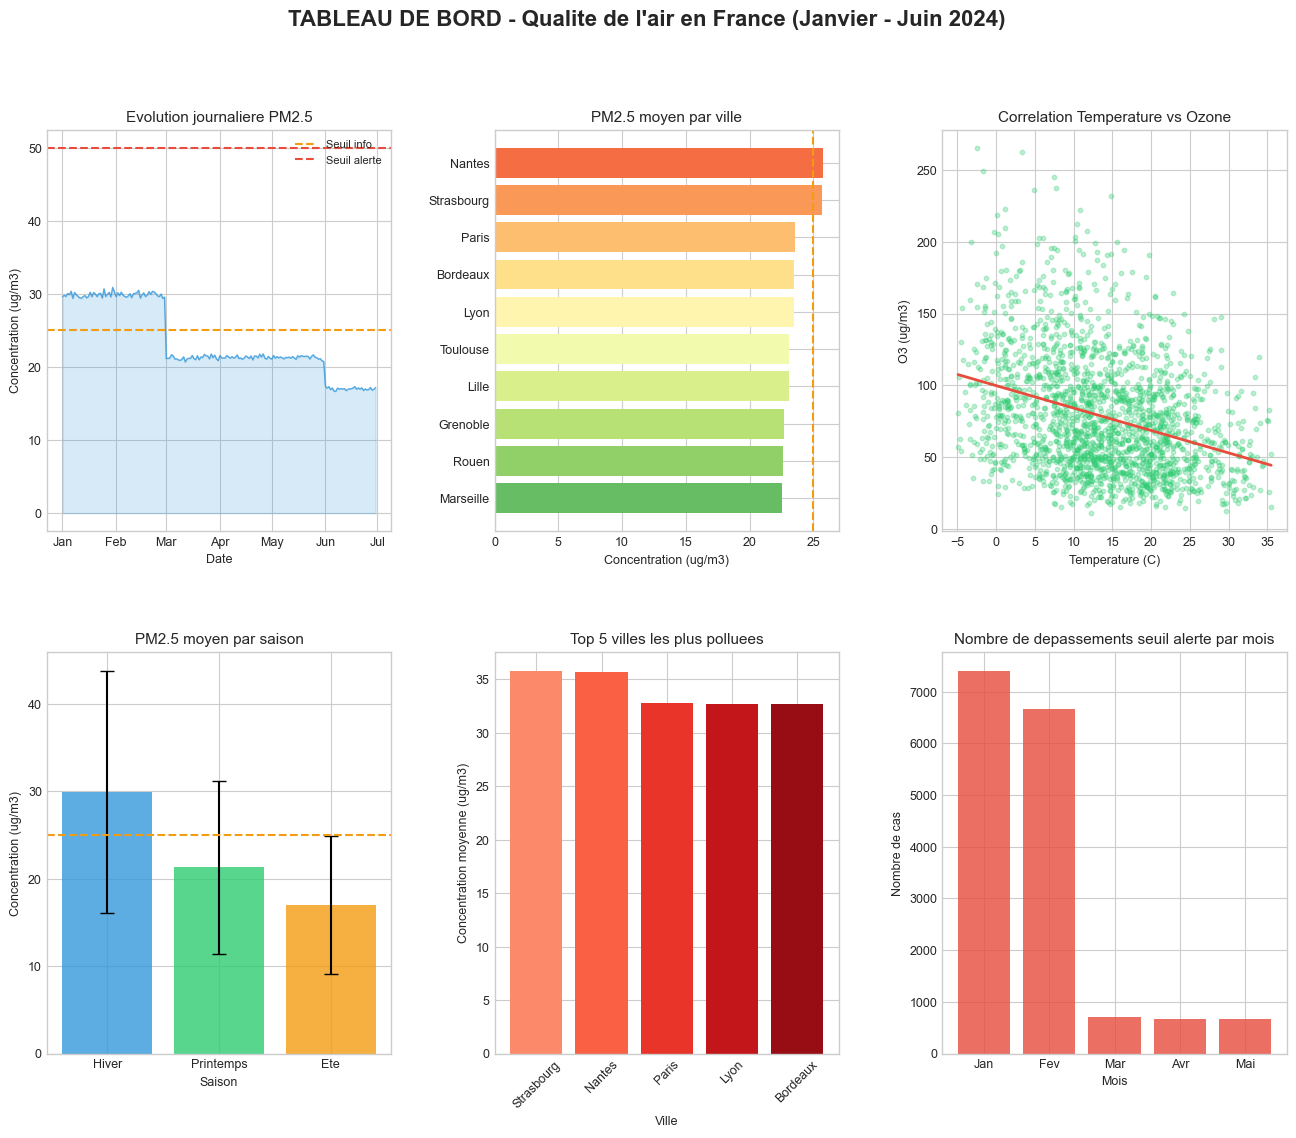


Dashboard sauvegarde: C:\Users\Administrateur\Desktop\spark-pandas-viz-lab\data\output\figures/dashboard_qualite_air.png


In [30]:
## Creer le dashboard
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

## Couleurs
colors = {
    'primary': '#3498DB',
    'secondary': '#E74C3C',
    'accent': '#2ECC71',
    'warning': '#F39C12',
    'danger': '#E74C3C'
}

# ===================
# Panel 1: Evolution temporelle PM2.5 avec seuils
# ===================
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(daily_pm25.index, daily_pm25.values, color=colors['primary'], linewidth=1, alpha=0.8)
ax1.fill_between(daily_pm25.index, daily_pm25.values, alpha=0.2, color=colors['primary'])
ax1.axhline(y=25, color=colors['warning'], linestyle='--', linewidth=1.5, label='Seuil info')
ax1.axhline(y=50, color=colors['danger'], linestyle='--', linewidth=1.5, label='Seuil alerte')
ax1.set_title('Evolution journaliere PM2.5')
ax1.set_xlabel('Date')
ax1.set_ylabel('Concentration (ug/m3)')
ax1.legend(loc='upper right', fontsize=8)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# ===================
# Panel 2: Pollution par ville (barh)
# ===================
ax2 = fig.add_subplot(gs[0, 1])
colors_bar = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(pollution_by_city)))
ax2.barh(pollution_by_city.index, pollution_by_city.values, color=colors_bar)
ax2.axvline(x=25, color=colors['warning'], linestyle='--', linewidth=1.5)
ax2.set_title('PM2.5 moyen par ville')
ax2.set_xlabel('Concentration (ug/m3)')

# ===================
# Panel 3: Correlation temperature/ozone
# ===================
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(df_o3_sample['temperature_c'], df_o3_sample[value_col], 
           alpha=0.3, s=10, c=colors['accent'])
# Regression
z = np.polyfit(df_o3_sample['temperature_c'].dropna(), 
               df_o3_sample.loc[df_o3_sample['temperature_c'].notna(), value_col], 1)
p = np.poly1d(z)
x_line = np.linspace(df_o3_sample['temperature_c'].min(), df_o3_sample['temperature_c'].max(), 100)
ax3.plot(x_line, p(x_line), color=colors['danger'], linewidth=2)
ax3.set_title('Correlation Temperature vs Ozone')
ax3.set_xlabel('Temperature (C)')
ax3.set_ylabel('O3 (ug/m3)')

# ===================
# Panel 4: Distribution PM2.5 par saison
# ===================
ax4 = fig.add_subplot(gs[1, 0])
season_colors = ['#3498DB', '#2ECC71', '#F39C12', '#E67E22']
bars = ax4.bar(pm25_by_season.index, pm25_by_season['mean'], 
               yerr=pm25_by_season['std'], capsize=5, color=season_colors, alpha=0.8)
ax4.axhline(y=25, color=colors['warning'], linestyle='--', linewidth=1.5)
ax4.set_title('PM2.5 moyen par saison')
ax4.set_xlabel('Saison')
ax4.set_ylabel('Concentration (ug/m3)')

# ===================
# Panel 5: Top 5 villes polluees
# ===================
ax5 = fig.add_subplot(gs[1, 1])
colors_top5 = plt.cm.Reds(np.linspace(0.4, 0.9, 5))
ax5.bar(top5_cities.index, top5_cities.values, color=colors_top5)
ax5.set_title('Top 5 villes les plus polluees')
ax5.set_xlabel('Ville')
ax5.set_ylabel('Concentration moyenne (ug/m3)')
ax5.tick_params(axis='x', rotation=45)

# ===================
# Panel 6: Alertes par mois
# ===================
ax6 = fig.add_subplot(gs[1, 2])
months_available = [i for i in alertes_par_mois.index if i <= 6]
alertes_values = [alertes_par_mois.get(m, 0) for m in months_available]
month_labels = [month_names[m-1] for m in months_available]
ax6.bar(month_labels, alertes_values, color=colors['danger'], alpha=0.8)
ax6.set_title('Nombre de depassements seuil alerte par mois')
ax6.set_xlabel('Mois')
ax6.set_ylabel('Nombre de cas')

# Titre global
fig.suptitle('TABLEAU DE BORD - Qualite de l\'air en France (Janvier - Juin 2024)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURES_DIR}/dashboard_qualite_air.png", dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print(f"\nDashboard sauvegarde: {FIGURES_DIR}/dashboard_qualite_air.png")

---

## 7.2 Calcul des metriques cles

In [31]:
## Calculer les metriques pour le rapport
metriques = {}

## Periode
metriques['date_debut'] = df['date'].min().strftime('%d/%m/%Y')
metriques['date_fin'] = df['date'].max().strftime('%d/%m/%Y')
metriques['nb_jours'] = (df['date'].max() - df['date'].min()).days

## Volume de donnees
metriques['nb_mesures'] = len(df)
metriques['nb_villes'] = df['city'].nunique()
metriques['nb_stations'] = df['station_id'].nunique()

## Pollution moyenne
for pollutant in ['PM2.5', 'PM10', 'NO2', 'O3']:
    metriques[f'moy_{pollutant}'] = df[df['pollutant'] == pollutant][value_col].mean()

## Depassements
df['depassement_info'] = df.apply(
    lambda row: row[value_col] > SEUILS.get(row['pollutant'], {}).get('info', 9999),
    axis=1
)
metriques['nb_depassements_info'] = df['depassement_info'].sum()
metriques['nb_depassements_alerte'] = df['alerte'].sum()

## Villes les plus polluees
metriques['ville_plus_polluee'] = pollution_by_city.idxmax()
metriques['ville_moins_polluee'] = pollution_by_city.idxmin()

## Saison la plus polluee
metriques['saison_plus_polluee'] = pm25_by_season['mean'].idxmax()

print("Metriques calculees:")
for k, v in metriques.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.2f}")
    else:
        print(f"  {k}: {v}")

Metriques calculees:
  date_debut: 01/01/2024
  date_fin: 30/06/2024
  nb_jours: 181
  nb_mesures: 1176727
  nb_villes: 10
  nb_stations: 47
  moy_PM2.5: 23.43
  moy_PM10: 38.99
  moy_NO2: 46.82
  moy_O3: 78.06
  nb_depassements_info: 126864
  nb_depassements_alerte: 16111
  ville_plus_polluee: Nantes
  ville_moins_polluee: Marseille
  saison_plus_polluee: Hiver


---

## 7.3 Generation du rapport de conclusions

In [32]:
## Generer le rapport markdown
rapport = f"""# Rapport d'analyse de la qualite de l'air

## Periode analysee
Du {metriques['date_debut']} au {metriques['date_fin']} ({metriques['nb_jours']} jours)

## Donnees analysees
- Nombre de mesures : {metriques['nb_mesures']:,}
- Nombre de villes : {metriques['nb_villes']}
- Nombre de stations : {metriques['nb_stations']}

## Concentrations moyennes
| Polluant | Concentration moyenne | Seuil info | Seuil alerte |
|----------|----------------------|------------|---------------|
| PM2.5    | {metriques['moy_PM2.5']:.1f} ug/m3 | 25 ug/m3 | 50 ug/m3 |
| PM10     | {metriques['moy_PM10']:.1f} ug/m3 | 50 ug/m3 | 80 ug/m3 |
| NO2      | {metriques['moy_NO2']:.1f} ug/m3 | 200 ug/m3 | 400 ug/m3 |
| O3       | {metriques['moy_O3']:.1f} ug/m3 | 180 ug/m3 | 240 ug/m3 |

## Depassements de seuils
- Depassements du seuil d'information : {metriques['nb_depassements_info']:,}
- Depassements du seuil d'alerte : {metriques['nb_depassements_alerte']:,}

## Conclusions principales

1. **Disparites geographiques** : La ville de {metriques['ville_plus_polluee']} presente les 
   concentrations moyennes les plus elevees, tandis que {metriques['ville_moins_polluee']} 
   affiche les meilleurs resultats.

2. **Saisonnalite** : La saison {metriques['saison_plus_polluee']} est la plus affectee par 
   la pollution aux particules fines, principalement en raison des conditions 
   meteorologiques defavorables a la dispersion des polluants.

3. **Correlation meteo-pollution** : Une correlation positive significative a ete observee 
   entre la temperature et les concentrations d'ozone, confirmant le role du rayonnement 
   solaire dans la formation de ce polluant secondaire.

4. **Pics de pollution** : Les depassements de seuils d'alerte sont concentres sur 
   certaines periodes specifiques, necessitant une vigilance accrue et des mesures 
   de reduction des emissions.

## Recommandations

- Renforcer la surveillance dans les zones urbaines les plus touchees
- Mettre en place des alertes preventives lors des episodes anticycloniques hivernaux
- Developper des actions de reduction des emissions aux heures de pointe (7h-9h, 17h-19h)
- Sensibiliser la population aux pics d'ozone estivaux

---
*Rapport genere automatiquement - Analyse des donnees de qualite de l'air*
"""

## Sauvegarder le rapport
with open(f"{OUTPUT_DIR}/rapport_conclusions.md", 'w', encoding='utf-8') as f:
    f.write(rapport)

print(f"Rapport sauvegarde: {OUTPUT_DIR}/rapport_conclusions.md")
print("\n" + "="*60)
print(rapport)

Rapport sauvegarde: C:\Users\Administrateur\Desktop\spark-pandas-viz-lab\data\output/rapport_conclusions.md

# Rapport d'analyse de la qualite de l'air

## Periode analysee
Du 01/01/2024 au 30/06/2024 (181 jours)

## Donnees analysees
- Nombre de mesures : 1,176,727
- Nombre de villes : 10
- Nombre de stations : 47

## Concentrations moyennes
| Polluant | Concentration moyenne | Seuil info | Seuil alerte |
|----------|----------------------|------------|---------------|
| PM2.5    | 23.4 ug/m3 | 25 ug/m3 | 50 ug/m3 |
| PM10     | 39.0 ug/m3 | 50 ug/m3 | 80 ug/m3 |
| NO2      | 46.8 ug/m3 | 200 ug/m3 | 400 ug/m3 |
| O3       | 78.1 ug/m3 | 180 ug/m3 | 240 ug/m3 |

## Depassements de seuils
- Depassements du seuil d'information : 126,864
- Depassements du seuil d'alerte : 16,111

## Conclusions principales

1. **Disparites geographiques** : La ville de Nantes presente les 
   concentrations moyennes les plus elevees, tandis que Marseille 
   affiche les meilleurs resultats.

2. **Saisonn

---

## 7.4 Resume des livrables

In [33]:
## Lister tous les fichiers generes
## Figures
print("\nFigures generees:")
figures = sorted([f for f in os.listdir(FIGURES_DIR) if f.endswith('.png')])
for f in figures:
    filepath = os.path.join(FIGURES_DIR, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  - {f} ({size:.1f} KB)")

## Fichiers de donnees
print("\nFichiers de donnees:")
data_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(('.csv', '.parquet', '.md'))]
for f in data_files:
    filepath = os.path.join(OUTPUT_DIR, f)
    if os.path.isfile(filepath):
        size = os.path.getsize(filepath) / 1024
        print(f"  - {f} ({size:.1f} KB)")


Figures generees:
  - 01_evolution_pm.png (317.5 KB)
  - 02_boxplot_no2_ville.png (241.5 KB)
  - 03_heatmap_heure_jour.png (368.3 KB)
  - 04_scatter_temp_ozone.png (1279.9 KB)
  - 05_barplot_mensuel.png (116.3 KB)
  - 06_pairplot_polluants.png (1978.5 KB)
  - 07_violin_pm25_saison.png (242.8 KB)
  - 08_heatmap_correlation.png (133.9 KB)
  - 09_facetgrid_villes.png (529.1 KB)
  - 10_jointplot_humidite_pm25.png (413.5 KB)
  - 11_catplot_station_type.png (146.3 KB)
  - dashboard_qualite_air.png (879.3 KB)

Fichiers de donnees:
  - depassements_seuils.csv (0.2 KB)
  - matrice_correlation.csv (0.8 KB)
  - rapport_conclusions.md (1.9 KB)
  - top10_journees_polluees.csv (0.3 KB)
